In [1]:
import numpy as np
from sklearn.datasets import fetch_openml
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

mnist = fetch_openml('mnist_784', version=1)
X, y = mnist['data'], mnist['target']

mask = (y == '0') | (y == '1')
X, y = X[mask], y[mask].astype(int).to_numpy()

scaler = StandardScaler()
X = scaler.fit_transform(X)


In [2]:
X = np.hstack((X, np.ones((X.shape[0], 1))*0.1))

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train = np.hstack((X_train, np.ones((X_train.shape[0], 1)) * 0.1))
X_test = np.hstack((X_test, np.ones((X_test.shape[0], 1)) * 0.1))

m, n = X_train.shape  # m: number of samples, n: features (including bias term)
C = 1.0

w = np.zeros(n)
xi = np.ones(m)

epsilon = 200
mu = 0.1
tol = 1e-5


In [3]:
# Barrier objective function
def barrier_objective(w, xi, epsilon):
    hinge_losses = -1 + y_train * (X_train @ w)
    hinge_losses = np.maximum(hinge_losses, 1e-6)
    xi = np.maximum(xi, 1e-6)
    barrier_term = -epsilon * (np.sum(np.log(xi)) + np.sum(np.log(hinge_losses)))
    objective = 0.5 * np.linalg.norm(w[:-1])**2 + C * np.sum(xi) + barrier_term
    return objective

# Barrier gradient calculation
def barrier_gradient(w, xi, epsilon):
    hinge_losses = 1 - y_train * (X_train @ w) + xi
    grad_w = w.copy()
    grad_xi = C - epsilon / (xi + 1e-5)

    active_set = (hinge_losses > 0)
    for i in range(m):
        if active_set[i]:
            grad_w -= (epsilon / hinge_losses[i]) * y_train[i] * X_train[i, :]
            grad_xi[i] += 1 - epsilon / hinge_losses[i]

    return grad_w, grad_xi

# Newton's method for updates
def newton_step(w, xi, epsilon):
    grad_w, grad_xi = barrier_gradient(w, xi, epsilon)
    step_w = -grad_w
    step_xi = -grad_xi

    # Line search to ensure positivity of xi
    alpha = 1.0
    while np.any(xi + alpha * step_xi <= 0):
        alpha *= 0.5

    w += alpha * step_w
    xi += alpha * step_xi
    return w, xi


In [4]:
# Optimization loop
iteration = 0
cost_values = []
while epsilon > tol:
    iteration += 1

    # Newton step
    w, xi = newton_step(w, xi, epsilon)
    cost_values.append(barrier_objective(w, xi, epsilon))

    # Update epsilon every 5 steps
    if iteration % 5 == 0:
        epsilon *= mu


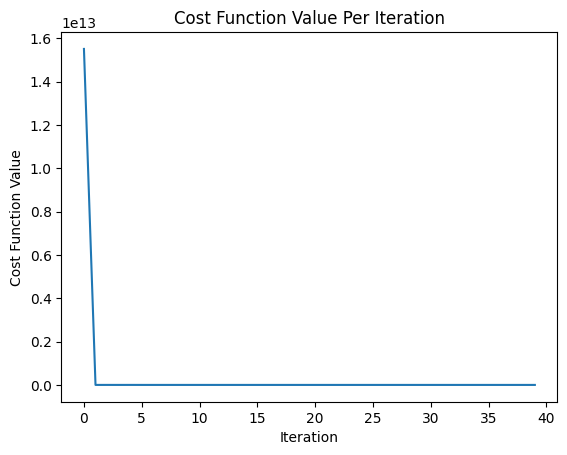

Test accuracy: 99.36%


In [5]:
# Plot cost function over iterations
plt.plot(cost_values)
plt.xlabel('Iteration')
plt.ylabel('Cost Function Value')
plt.title('Cost Function Value Per Iteration')
plt.show()

# Classification and accuracy on test data
predictions = np.sign(X_test @ w)
predictions = (predictions + 1) // 2
accuracy = np.mean(predictions == y_test)

print(f"Test accuracy: {accuracy * 100:.2f}%")
